# Выбор локации для скважины

Аналитик добывающей компании «ГлавРосГосНефть» должен предоставить рекомендации, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализирем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание проекта

Цель проекта - выбрать один из трех регионов для последующей разработки исходя из прогнозируемых показателей ожидаемой рентабельности, а также оценки риска проекта.

В нашем распоряжении имеются данные разведки по трем регионам, из которых нам предстоит выбрать один наиболее перспективный. По каждому региону имеются 100 тыс. точек данных, каждая из которых включает три обезличенных признака и целевой признак - объем запасов (в тыс. баррелей).

На первом этапе проведем предобработку и исследование данных: проверим наличие пропусков, выбросов и аномалий в данных, наличие корреляций признаков между собой, а также признаков и целевого признака. Проведем нормирование данных.

Далее, в соответствии с условиями задачи обучим модель линейной регрессии для каждого региона на имеющихся датасетах. Исходные датафреймы будут разделены на обучающую и валидационную выборки в пропорциях 75:25 соответственно. Обученные модели будут использованы для прогнозирования рентабельности разработки каждого региона.

В следующем разделе проведем моделирование методом монте - карло: из валидационной выборки случайным образом отбираются 500 объектов, содержащих как предсказание на основе модели, так и значения фактического объема запасов. Из них отбираются 200 объектов с максимальным прогнозируемым объемом добычи. После чего производится сравнение с фактическими значениями.

Завершает работу раздел выводов.

#### Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

#### Зададим некоторые общие настройки

In [2]:
pd.options.display.float_format = '{:.2f}'.format
sns.set_theme()

#### Константы

In [3]:
#бюджет 10 млрд руб
TOTAL_BUDGET_RUB = 10 * 10 ** 9
#цена одной ед продукта
PRODUCT_PRICE_RUB = 450000
#количество ед продукта в регионе для окупаемости инвестиций
BREAK_EVEN_PROD_TOTAL = TOTAL_BUDGET_RUB / PRODUCT_PRICE_RUB
#бюджет на разработку одной скважины (исходя из общего количества 200 скважин)
BUDGET_PER_WELL = TOTAL_BUDGET_RUB / 200
#количество ед продукта для окупаемости инвестиций в разработку одной скважины
BREAK_EVEN_PROD_PER_WELL = BUDGET_PER_WELL / PRODUCT_PRICE_RUB

#### Пользовательские функции

In [4]:
def split_dataframe(dataframe):
    """Функция выделяет из принятого аргументом датафрейма отдельно признаки и отдельно целевой признак,
    далее разбивает их на обучающую и валидационную выборки,
    возвращает четыре датафрейма"""
    
    #выделим фичи и таргет
    features = dataframe[['f0', 'f1', 'f2']]
    target = dataframe['product']
    
    #разобьем на обучающую и валидационную выборки
    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size=0.25, random_state = 12345)
        
    features_train = pd.DataFrame(features_train)
    features_valid = pd.DataFrame(features_valid)
    target_train = pd.DataFrame(target_train)
    target_valid = pd.DataFrame(target_valid)
        
    features_train = features_train.reset_index(drop = True)
    features_valid = features_valid.reset_index(drop = True)
    target_train = target_train.reset_index(drop = True)
    target_valid =  target_valid.reset_index(drop = True)
    
    return features_train, features_valid, target_train, target_valid

In [5]:
def init_database(dataframes_list):
    """Функция принимает список предобработанных датафреймов без предварительного разбиения / разделения,
    для каждого из них:
    из функции split_datframe принимает четыре объекта,
    собрает и возвращает из набора признаков и целевых признаков разделенных на 
    обучающую и валидационную выборки упорядоченное хранилище объектов"""
    
    #для удобства автоматизации дальнейшей обработки импровизируем минибазу для хранения фичей и таргетов.
    #словарь в кач-ве базы: ключ помогает извлечь фичу или таргет на обучающей или валидационной выборках,
    #индекс структурирует по очередности обработки / добавления в "базу"
    
    #из минусов - len не вернет количество содержащихся внутри исходных датафреймов
    minibase = {}
    
    #списки как объекты словаря упорядочены по порядку добавления
    list_of_features_train = []
    list_of_features_valid = []
    list_of_target_train = []
    list_of_target_valid = []
    
    for dataframe in dataframes_list:
        #передадим датафрейм с предобработанной датой в функцию разделения
        features_train, features_valid, target_train, target_valid = split_dataframe(dataframe)
        #наполним нашу минибазу
        list_of_features_train.append(features_train)
        list_of_features_valid.append(features_valid)
        list_of_target_train.append(target_train)
        list_of_target_valid.append(target_valid)
        
    #упорядочим словарь: добавим ключи и соответствующие наполненные списки
    minibase = {'features_train': list_of_features_train, 'features_valid': list_of_features_valid, 
            'target_train': list_of_target_train, 'target_valid': list_of_target_valid}
    
    return minibase

In [6]:
def fit_models(minibase):
    """функция обучает модели и возвращает список обученных моделей"""
    
    #обученные модели сохраним в списке
    fitted_models_list = []
    
    print('Обучаем модели.')
    #обучим модельки
    for i in range(3):
        model = LinearRegression()
        features_train = minibase['features_train'][i]
        target_train = minibase['target_train'][i]
        model.fit(features_train, target_train)
        #выведем что нибудь полезное на экран, чтобы понимать, что скрипт работает
        print('Константа модели {}: {:.2f}'.format(i, model.intercept_[0]))
        print('Коэффициенты модели {}: {:.2f}, {:.2f}, {:.2f}' \
              .format(i, model.coef_[0][0], model.coef_[0][1], model.coef_[0][2]))
        print()
        #модельки складываем в список
        fitted_models_list.append(model)
    #и возвращаем
    print('Модели обучены и сохранены.')
    print()
    return fitted_models_list

#напоминалка: для дальнейшего переиспользования аргументы, счетчик цикла,
#вызов объектов из словаря нужно будет переогранизовать

In [7]:
def get_predictions(fitted_models_list):
    """По обученным моделям функция делает прогноз на валидационной выборке,
    выводит на экран метрики моделей и возвращает список с предсказаниями"""
    
    print('Составляем прогноз запасов.')
    print()
    #подготовим список для предсказаний
    predictions_list = []
    #подготовим список для средних значений
    prod_means_list = []
    
    for i in range(3):
        print('Расчет прогноза по модели для региона {}.'.format(i))
        
        #вынимаем модель из списка моделей
        model = fitted_models_list[i]
        
        #извлекаем фичи и таргет для валидационной выборки для соотв. модели
        features_valid = minibase['features_valid'][i]
        target_valid = minibase['target_valid'][i]
        
        #прогнозируем и выводим метрики и прогнозные значения
        predictions_valid = pd.DataFrame(model.predict(features_valid), index=features_valid.index,
                                     columns = ['predicted'])
        prod_mean = predictions_valid.mean()
        rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
        print("Средний запас (прогноз, тыс. баррелей): {:.2f}".format(prod_mean['predicted']))
        print("RMSE модели линейной регрессии на валидационной выборке: {:.2f}".format(rmse))
        print()
        
        #оценку на одекватность проведем прогнозом по среднему арифм. таргета
        print('Оценка адекватности модели.')
        predictions_dummy = pd.DataFrame(target_valid['product'].mean(), index=target_valid.index,
                                 columns = ['dummy'])
        rmse_dummy = mean_squared_error(target_valid, predictions_dummy) ** 0.5
        print("RMSE предсказания по среднему значению валидационной выборки: {:.2f}".format(rmse_dummy))
        if rmse < rmse_dummy:
            print('Ошибка обученной модели ниже случайной.')
        if rmse > rmse_dummy:
            print('Ошибка обученной модели выше случайной.')
        if rmse == rmse_dummy:
            print('Модель выдает результат, равный случайному.')
        print("---")
        print()
        
        #склеим факт с прогнозом
        predictions_valid = pd.concat([target_valid, predictions_valid], axis = 1)
        predictions_valid = predictions_valid.reset_index(drop = True)
        #и сложим в заготовленный списочек
        predictions_list.append(predictions_valid)
        #сохраним средние значения прогноза
        prod_means_list.append(prod_mean)
        
    print('Прогнозирование выполнено, прогнозы сохранены.')
    print()
    return predictions_list, prod_means_list

In [8]:
def analyse_means(prod_mean, i):
    """первые шаги к разработке искусственного интеллекта"""
    
    print('Средний запас сырья в регионе {}, прогнозное значение: {:.2f}, тыс. баррелей' \
          .format(i, prod_mean['predicted']))
    
    if prod_mean['predicted'] < BREAK_EVEN_PROD_PER_WELL:
        print('Прогноз среднего ниже точки окупаемости ({:.2f}).'.format(BREAK_EVEN_PROD_PER_WELL))
    if prod_mean['predicted'] > BREAK_EVEN_PROD_PER_WELL:
        print('Прогноз среднего выше точки окупаемости ({:.2f}).'.format(BREAK_EVEN_PROD_PER_WELL))
    if prod_mean['predicted'] == BREAK_EVEN_PROD_PER_WELL:
        print('Прогноз среднего равен точке окупаемости ({:.2f}).'.format(BREAK_EVEN_PROD_PER_WELL))

In [9]:
def calc_pl(sample_sorted):
    """расчитаем приб. /убыток как суммарную добычу на двухста отобранных участках
    домноженную на стоимость единицы продукта и за вычетом суммарных инвестиций на разработку в регионе"""
    return (sample_sorted['product'].sum() * PRODUCT_PRICE_RUB - TOTAL_BUDGET_RUB) / 10**6

In [10]:
def boot_strap(data):
    """
    - Функция принимает датасет с предсказаниями и фактическим значением запасов.
    - Случайным образом отбираются пятьсот точек данных.
    - Из них отбираем двести с максимальными значениями прогноза добычи и считаем сумму.
    - Суммы сохраняем и возвращаем.
    - Также ведем счетчик потерь.
    """
    
    
    nloops = 1000
    #списки для возврата
    returns_list = []
    losses_counter = 0
    for _ in range(nloops):
        #случайный отбор с возвратом
        sample = data.sample(500, replace = True)
        #сортировка
        sample_sorted = sample.sort_values(by = ['predicted'], ascending = False)
        #удаление лишних результатов
        sample_sorted = sample_sorted[:200]
        #сброс индексов
        sample_sorted = sample_sorted.reset_index(drop = True)
        #расчет прибыли
        returns_rub = calc_pl(sample_sorted)
        #расчет количества убыточных ситуаций
        if returns_rub < 0:
            losses_counter += 1
        returns_list.append(returns_rub)
    
    returns_list = pd.DataFrame(returns_list, columns = ['p/l'])
    return returns_list, (losses_counter / nloops)

In [11]:
def analyse_returns(data, i):
    
    #получили результаты бутстрап
    returns_list, losses_counter = boot_strap(data)
    
    #вероятность убытка: сколько раз из тысячи суммарная прибыль на 200 участках была меньше нуля
    print("Вероятность получить убыток в регионе {} составляет {:.2%}".format(i, losses_counter))
    
    #участки с повышенным риском пропускаем в соотв. с условием задачи
    if (losses_counter) > 0.025:
        print('Регион {} не проходит по рискам. Регион отклоняем.'.format(i))
        
    if (losses_counter) <= 0.025:
        print('Разберем результаты моделирования региона {} подробнее.'.format(i))
        print('Метрики распределения и гистограмма. В млн. руб.')
        print(returns_list.describe())
        lower = returns_list.quantile(0.025)
        upper = returns_list.quantile(0.975)
        mean = returns_list.mean()
        f, ax = plt.subplots(figsize = (12, 9))
        sns.histplot(returns_list, bins = 50, ax = ax)
        plt.title('Распределение прибыли по региону {}'.format(i))
        plt.xlabel('Величина прибыли (убытка), в млн. руб.')
        plt.ylabel('Частота выпадения')
        #ax.axvline(x = lower, color = 'r')
        #ax.axvline(x = upper, color = 'g')
        #ax.axvline(x = mean, color = 'b')
        plt.show()
        print('Среднее значение прибыли: {:.2f}, млн. руб.'.format(mean[0]))
        print("Доверительный интервал 95%. Нижний предел: {:.2f}. Верхний предел: {:.2f}. В млн. руб."\
              .format(lower[0], upper[0]))
    
    print()

## Загрузка и подготовка данных

Прочитаем исходные данные и сформируем три датафрейма для каждого региона.

In [12]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')

Выведем сводную информацию по датафреймам и первые пять строк каждого.

In [13]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [14]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [15]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [16]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [17]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [18]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Предварительно можем сделать вывод об отсутствии пропусков в данных и о том, что типы данных не нуждаются в изменении. Далее построим гистограммы данных и применим метод .describe() с целью оценить наличие выбросов и аномалий, а также характер распределения величин.

In [19]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [20]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [21]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


Выбросы и аномалии не наблюдаются.

Оценим разброс целевого признака.

In [22]:
geo_data_0['product'].describe()['mean'] / geo_data_0['product'].describe()['std']

2.0885692854225923

In [23]:
geo_data_1['product'].describe()['mean'] / geo_data_1['product'].describe()['std']

1.4980055393744045

In [24]:
geo_data_2['product'].describe()['mean'] / geo_data_2['product'].describe()['std']

2.122908772366797

In [25]:
geo_data_0['product'].describe()['75%'] - geo_data_0['product'].describe()['25%']

72.06658231164474

In [26]:
geo_data_1['product'].describe()['75%'] - geo_data_1['product'].describe()['25%']

80.85978309461908

In [27]:
geo_data_2['product'].describe()['75%'] - geo_data_2['product'].describe()['25%']

71.14458577714484

С точки зрения спреда целевого признака, оцененного через стандартное отклонение и через межквартильные интервалы, предположу, что целевой признак для geo_data_0 и geo_data_2 (при прочих равных условиях) должен поддаваться прогнозированию проще.

Ниже оценим характер распределения.

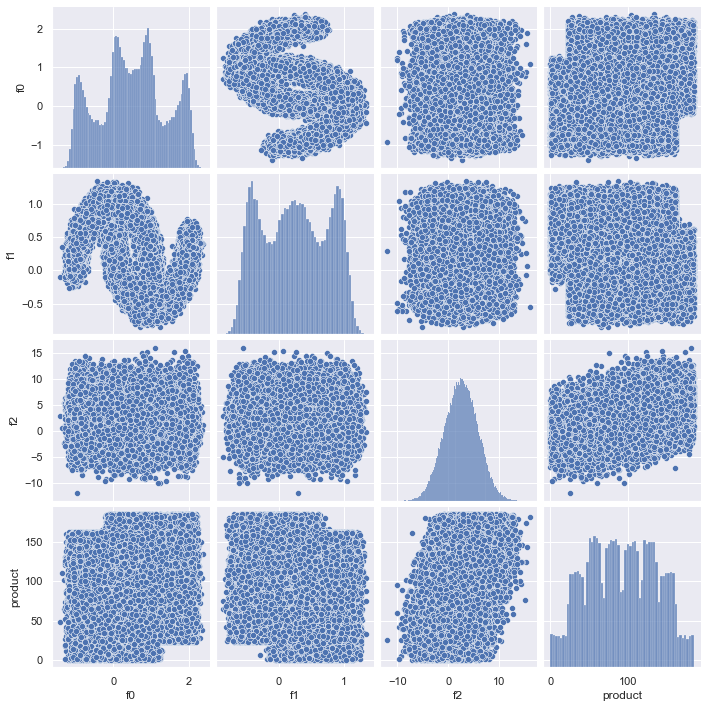

In [28]:
sns.pairplot(geo_data_0[['f0','f1','f2','product']])

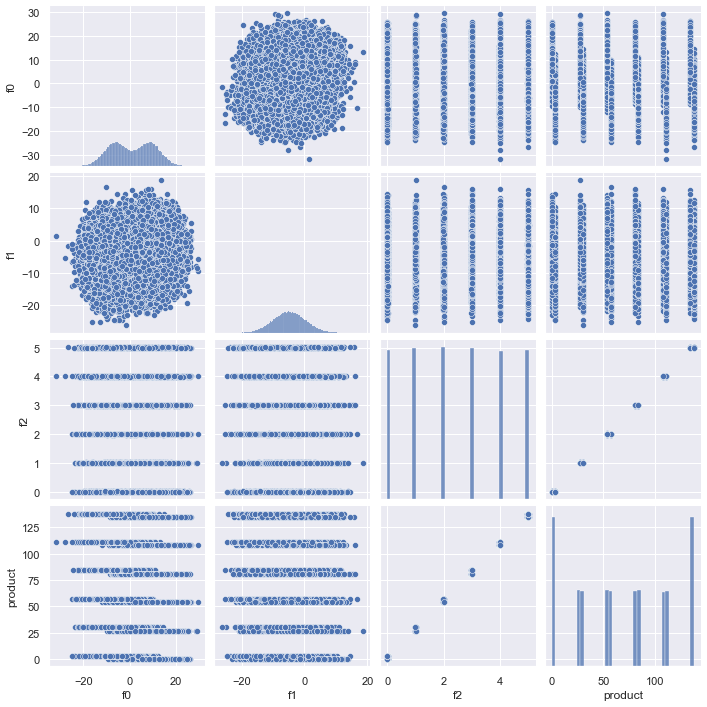

In [29]:
sns.pairplot(geo_data_1[['f0','f1','f2','product']])

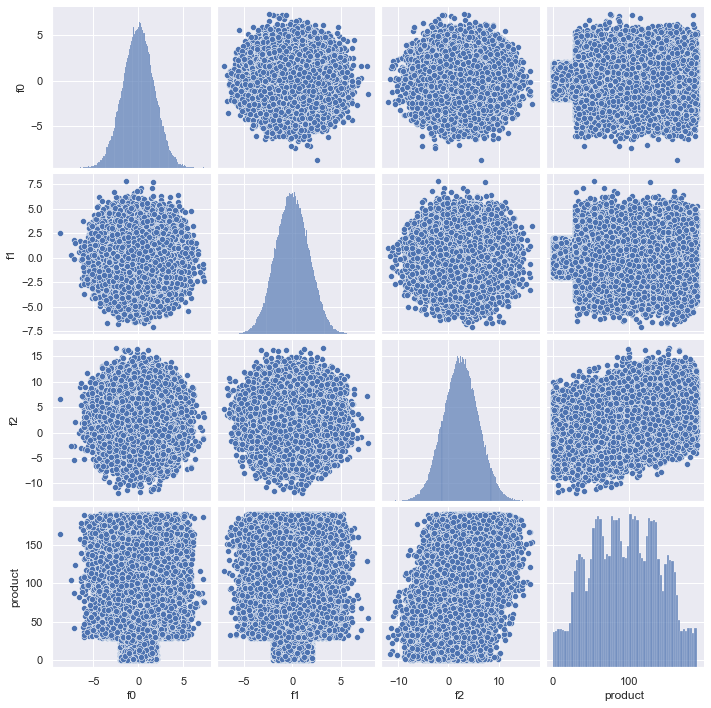

In [30]:
sns.pairplot(geo_data_2[['f0','f1','f2','product']])

В целом, большинство распределений стремятся к форме нормального. Распределения некоторых признаков (включая целевые) содержат несколько пиков.

Отдельно обращает внимание любопытная корреляция между f0 и f1 в geo_data_0. Кроме того, явно высокая корреляция между f2 и product в geo_data_1. Можем предположить метрики линейной регрессии для второго региона будут близки к единице.

Построим корреляционные матрицы, чтобы уточнить наличие зависимостей.

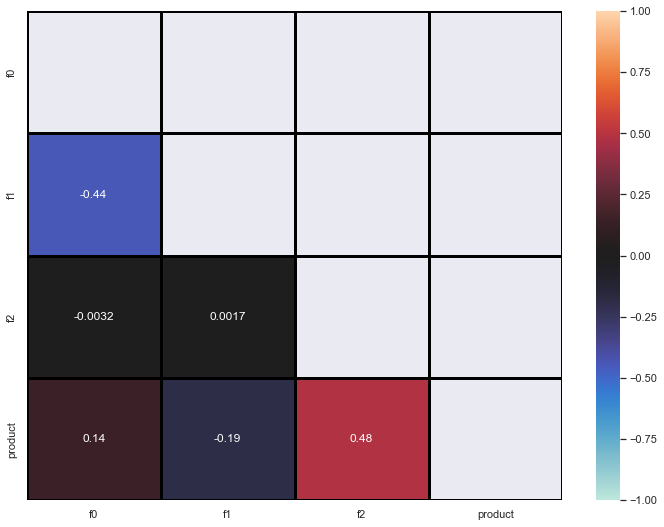

In [31]:
matrix = np.triu(geo_data_0.corr())
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(geo_data_0.corr(), annot = True, fmt='.2g', vmin = -1, vmax = 1, center = 0, 
            linewidths=3, linecolor='black', mask=matrix, ax = ax)
plt.show()

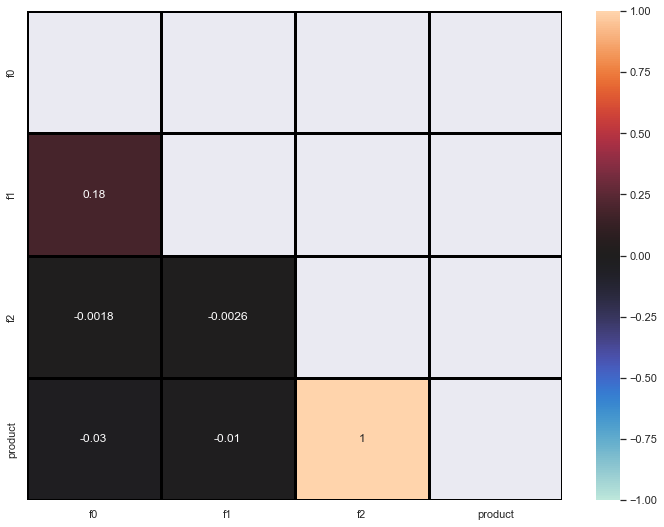

In [32]:
matrix = np.triu(geo_data_1.corr())
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(geo_data_1.corr(), annot = True, fmt='.2g', vmin = -1, vmax = 1, center = 0, 
            linewidths=3, linecolor='black', mask=matrix, ax = ax)
plt.show()

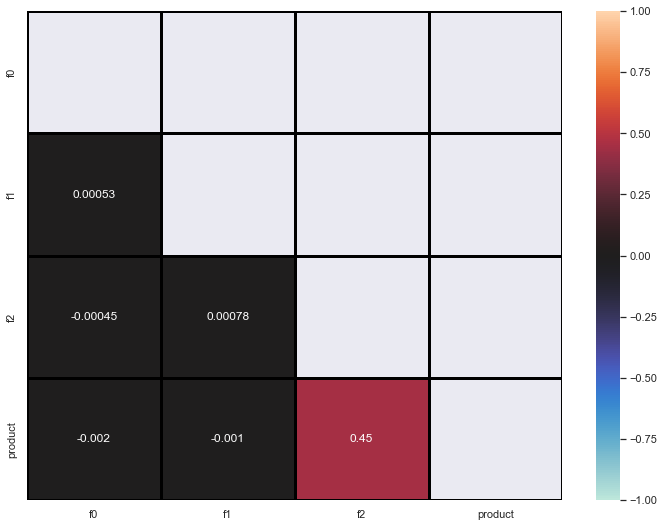

In [33]:
matrix = np.triu(geo_data_2.corr())
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(geo_data_2.corr(), annot = True, fmt='.2g', vmin = -1, vmax = 1, center = 0, 
            linewidths=3, linecolor='black', mask=matrix, ax = ax)
plt.show()

Максимальная корреляция с целевым признаком у значений колонки f2 для всех трех датафреймов.

Подтверидлась высокая корреляция между признаками f0 и f1 в датафрейме geo_data_0.

Предобработка в рамках данного отчета получилась совмещена с исследовательским анализом. Предобработка практически не потребовалась: пропущенные даные, выбросы / аномалии не обнаружены.

Выявили имеющиеся взаимосвязи между признаками. Можем перейти к обучению моделей.

## Обучение и проверка модели

В данном разделе проведем разделение исходных датафреймов и выделим целевой признак (product).

Также разобьем выборки на обучающую и валидационную.

Далее непосредственно обучим модель и оценим метрики. Помимо указанной в задании к проекту метрики RMSE в целях закрепления навыка рассчитаем также метрики R2 и MAE.

Для каждой задачи из вышеприведенных подготовлена соответствующая функция для расчета. Приступим:

In [34]:
#список с исходными датафреймами до внесения каких либо изменений
data_list = [geo_data_0, geo_data_1, geo_data_2]

#получим словарь списков разделенных на фичи и таргет и на валидационную и обучающую выборки трех датафреймов
minibase = init_database(data_list)

In [35]:
#список с тремя обученными моделями
fitted_models_list = fit_models(minibase)

Обучаем модели.
Константа модели 0: 77.86
Коэффициенты модели 0: 3.59, -14.10, 6.59

Константа модели 1: 1.66
Коэффициенты модели 1: -0.14, -0.02, 26.95

Константа модели 2: 80.78
Коэффициенты модели 2: 0.03, -0.04, 5.71

Модели обучены и сохранены.



In [36]:
#список с тремя датафреймами, содержащими целевой признак и сделанный прогноз на валидационных выборках,
#а также список со средними значениями прогноза
predictions_list, prod_means_list = get_predictions(fitted_models_list)

Составляем прогноз запасов.

Расчет прогноза по модели для региона 0.
Средний запас (прогноз, тыс. баррелей): 92.59
RMSE модели линейной регрессии на валидационной выборке: 37.58

Оценка адекватности модели.
RMSE предсказания по среднему значению валидационной выборки: 44.29
Ошибка обученной модели ниже случайной.
---

Расчет прогноза по модели для региона 1.
Средний запас (прогноз, тыс. баррелей): 68.73
RMSE модели линейной регрессии на валидационной выборке: 0.89

Оценка адекватности модели.
RMSE предсказания по среднему значению валидационной выборки: 46.02
Ошибка обученной модели ниже случайной.
---

Расчет прогноза по модели для региона 2.
Средний запас (прогноз, тыс. баррелей): 94.97
RMSE модели линейной регрессии на валидационной выборке: 40.03

Оценка адекватности модели.
RMSE предсказания по среднему значению валидационной выборки: 44.90
Ошибка обученной модели ниже случайной.
---

Прогнозирование выполнено, прогнозы сохранены.



Вывод:

Максимальные метрики модели для второго региона.

Максимальный средний запас (прогноз) у третьего региона.

## Подготовка к расчёту прибыли

Основные параметры для расчета.

In [37]:
print('Бюджет проекта: {:.2f}, млрд. руб.'.format(TOTAL_BUDGET_RUB / 10 ** 9))

Бюджет проекта: 10.00, млрд. руб.


In [38]:
print('Стоимость 1 ед. продукта: {:.2f}, тыс. руб.'.format(PRODUCT_PRICE_RUB / 10 ** 3))

Стоимость 1 ед. продукта: 450.00, тыс. руб.


In [39]:
print('Бюджет одной скважины: {:.2f}, млн. руб.'.format(BUDGET_PER_WELL / 10 ** 6))

Бюджет одной скважины: 50.00, млн. руб.


In [40]:
print('Количество ед. продукта, треб. для безубыточности скважины: {:.2f}, тыс. баррелей.' \
      .format(BREAK_EVEN_PROD_PER_WELL))

Количество ед. продукта, треб. для безубыточности скважины: 111.11, тыс. баррелей.


In [41]:
i = 0
for prod_mean in (prod_means_list):
    analyse_means(prod_mean, i)
    i += 1

Средний запас сырья в регионе 0, прогнозное значение: 92.59, тыс. баррелей
Прогноз среднего ниже точки окупаемости (111.11).
Средний запас сырья в регионе 1, прогнозное значение: 68.73, тыс. баррелей
Прогноз среднего ниже точки окупаемости (111.11).
Средний запас сырья в регионе 2, прогнозное значение: 94.97, тыс. баррелей
Прогноз среднего ниже точки окупаемости (111.11).


Вывод:

Система сделала вывод, что среднего запаса недостаточно для окупаемости. Придется добывать больше среднего.

## Расчёт прибыли и рисков 

Ранее сохраненные предсказания для каждого региона передадим в качестве аргумента в формулу для бутстрепа, получим распределение прибыли для каждого региона.

Расчитаем значение средней прибыли, доверительный интервал и вероятность убытка.

Сформулируем выводы.

Вероятность получить убыток в регионе 0 составляет 9.50%
Регион 0 не проходит по рискам. Регион отклоняем.

Вероятность получить убыток в регионе 1 составляет 0.80%
Разберем результаты моделирования региона 1 подробнее.
Метрики распределения и гистограмма. В млн. руб.
          p/l
count 1000.00
mean   457.65
std    201.65
min   -138.03
25%    314.35
50%    460.95
75%    596.30
max   1109.76


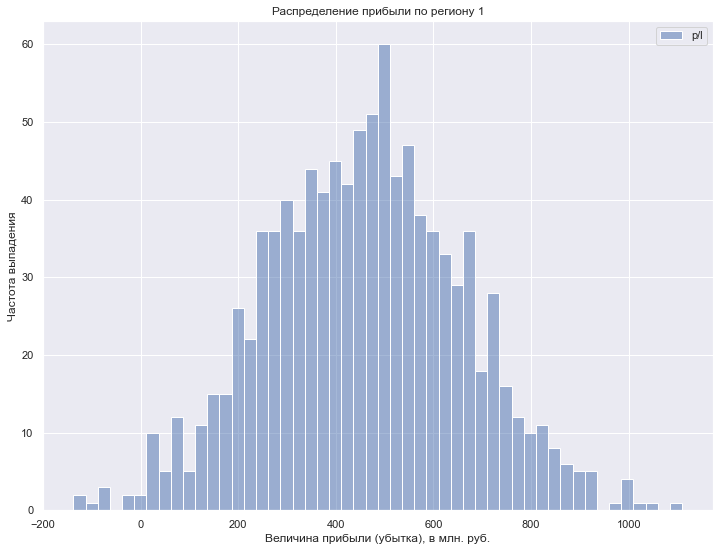

Среднее значение прибыли: 457.65, млн. руб.
Доверительный интервал 95%. Нижний предел: 63.77. Верхний предел: 850.26. В млн. руб.

Вероятность получить убыток в регионе 2 составляет 8.10%
Регион 2 не проходит по рискам. Регион отклоняем.



In [42]:
i = 0
for data in predictions_list:
    analyse_returns(data, i)
    i += 1

Расчеты показывают, что вероятность получить убыток ниже 2,5 % у второго региона. Исходя из расчетов рекомендуем второй регион.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован